# Appling machine learning to audio analysis

First we want to upload our labeled and unlabeled dataset for future use to train our model

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Sequential: creates a sequential model, ideal to create plain stack of layers
# each layer has exactly one input tensor and one output tensor

# Layers: basic building blacks of neural networks in Keras, consists of a
# tensor-in and tensor-out computation function and some state

# Dense, Dropout and Activartion are classes from layers:
# Activation and dense: Core layers. Activation applies an activation function
# to an output. The output has the same shape as the input.
# Dropout: regularization layer.

# Adam: it's an algorithm, an optimization, stochastic gradient descent method
#based on adaptive estimation of first and second order moments.

# to_categorical: converts a class vectors (integers) to a binary class matrix


In [4]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [5]:
# To play audio file:
import IPython.display as ipd

In [6]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/4595fd200a904a17979327e1e0952ec5



In [7]:
# Load dataset
df = pd.read_csv('../csvFiles/set_a.csv')


# Create a list of the labels. Currently there are 5 labels: 'artifact', 'extrahls', 'murmur', 'normal', 'unlab'
labels = list(df['label'].unique())
print(labels)

['artifact', 'extrahls', 'murmur', 'normal', 'unlab']


In [8]:
# grabs a single audio file from each class
files = dict()
datasetSize = 1

#Iteration over the labels and 

for i in range(len(labels)):
    
    #if the dataset contains itens with  the iterated label
    labelBoolean = (df['label'] == labels[i])
    #pick those items and make a new dataFrame with a spefic size
    dfItem = df[labelBoolean][:datasetSize]
    #reset the index to for easier selection
    tmp = dfItem.reset_index()
    #string with the directory
    path = '{}'.format(tmp['fname'][0])
    #save the string to the dictionary
    print(path)
    files[labels[i]] = '../' + path


set_a/artifact__201012172012.wav
set_a/extrahls__201101070953.wav
set_a/murmur__201101051104.wav
set_a/normal__201101070538.wav
set_a/Aunlabelledtest__201012172010.wav


../set_a/artifact__201012172012.wav


/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


EOFError: 

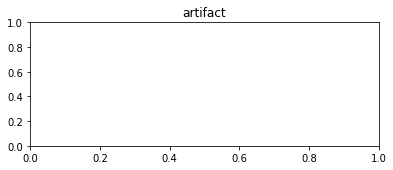

In [9]:
# To plot the waveforms, using librosa's display.waveplot function:

fig = plt.figure(figsize=(15,15))
#experiment.log_image('label_examples.png')
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)


for i, lab in enumerate(labels):
    # i = index
    # lab = name of the label at current index
    fn = files[lab]
    print(fn)
    fig.add_subplot(5,2,1+i)
    plt.title(lab)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr = sample_rate)
    
plt.savefig('../images/label_examples.png')

# Log graphic of waveforms to comet:
experiment.log_image('../images/label_examples.png')

In [ ]:
# Log audio files to Comet for debugging
for label in labels:
    fn = files[label]
    experiment.log_audio(fn, metadata = {'name': label})

## Preprocessing

In [ ]:
#pick an audio file
fn = files["artifact"]
#get its sample rate and librosa sample rate and bit depth
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)

print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

In [ ]:
#plot the original audio
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('../images/original_audio.png')
experiment.log_image('../images/original_audio.png')

In [ ]:
# plot the librosa audio mono sound
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)
plt.savefig('../images/librosa_audio.png')
experiment.log_image('../images/librosa_audio.png')

<h2> Separating S1 and S2

In [ ]:
timing = pd.read_csv('set_a_timing.csv')

In [ ]:
S1 = dict()
S2 = dict()

file_name = list(timing['fname'].unique())

for i in file_name:
    S1[i] = []
    S2[i] = []

for i in range(len(timing)):
    if timing.sound[i] == 'S1':
        S1[timing.fname[i]].append(timing.loc[i,'location'])
    else:
        S2[timing.fname[i]].append(timing.loc[i,'location'])
        

In [ ]:
# function to track time and beats from every audio
def extract_beat(file_name):
    audio, sample_rate = librosa.load(file_name) 
    # tracks the beats using time series input
    tempo, beats = librosa.beat.beat_track(audio, sr=sample_rate)
    return tempo, beats

In [ ]:
# plots the mel spectogram of one audio
hop_length = 512
tempo, beats = librosa.beat.beat_track(librosa_audio, sr=librosa_sample_rate)
onset_env = librosa.onset.onset_strength(librosa_audio, sr=librosa_sample_rate, aggregate=np.median)
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(onset_env, sr=librosa_sample_rate, hop_length=hop_length)
M = librosa.feature.melspectrogram(librosa_audio, sr=librosa_sample_rate, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[0])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
ax[1].plot(times, librosa.util.normalize(onset_env), label='Onset strength')
ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
ax[1].legend()

In [ ]:
# list for the beats, time, label
beats = [] 
time = []
labels = []

In [ ]:
# Iterate through each sound file and extract the beats 
for index, row in df.iterrows():
    
    absolutePath = os.path.abspath("")
    fname = str(row["fname"])
    file_name = os.path.join(absolutePath,fname)
    
    class_label = row["label"]
    
    if(class_label != "unlab"):
        data = extract_beat(file_name)
        time.append(data[0])
        beats.append(data[1])
        labels.append(class_label)
    
# Convert into a Panda dataframe
tb_df = pd.DataFrame(list(zip(beats, time, labels)), columns=['beats','time','class_label'])

In [ ]:
tb_df

## MFCCs - Mel-Frequency Cepstrum Coefficients

### Extract coefficients from only one file

In [ ]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 40)
print(mfccs.shape)

In [ ]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('../images/MFCCs.png')
experiment.log_image('../images/MFCCs.png')

### Function to extract the MFCCs from every file in our dataset

In [ ]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
     
    return mfccs_processed

In [ ]:
features = []# Iterate through each sound file and extract the features 

for index, row in df.iterrows():
    
    absolutePath = os.path.abspath("../")
    fname = str(row["fname"])
    file_name = os.path.join(absolutePath,fname)
    
    class_label = row["label"]
    
    if(class_label != "unlab"):
        data = extract_features(file_name)
        features.append([data, class_label])
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

In [ ]:
featuresdf.head()

In [ ]:
featuresdf.iloc[0]['feature']

## Model building and training

In [ ]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

### Trainning and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

### Neural Network architecture

In [ ]:
num_labels = yy.shape[1]

filter_size = 2

def build_model_graph(input_shape=(40,)):
    model = Sequential()
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
    
    return model

model = build_model_graph()

# Display model architecture summary 
model(x_train)
model.summary()# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

### Model Trainning

In [ ]:
num_epochs = 100
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

In [ ]:
experiment.end()